# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [1]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [2]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [3]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier01.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [4]:
df_Wine.shape

(3301, 25)

In [5]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [6]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [7]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [8]:
df_GeoCache.shape

(1224, 8)

In [9]:
df_Flag.shape

(19, 3)

In [10]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
1575,2005,76,2002,91.0,40,Turnbull,Cabernet Sauvignon Napa Valley,Red,Cabernet Sauvignon,NaN,...,2005.0,2012.0,"Elegant and polished, with a complex array of ...",Hierarchy_01,"California, USA","California, United States","(36.7014631, -118.755997, 0.0)",36.701463,-118.755997,0.0
2323,1997,24,1993,94.0,60,Shafer,Cabernet Sauvignon Stags Leap District Hillsid...,Red,Cabernet Sauvignon,NaN,...,1999.0,NaN,"A big, broad wine, generous and lush in flavor...",Hierarchy_01,"California, USA","California, United States","(36.7014631, -118.755997, 0.0)",36.701463,-118.755997,0.0
1741,2003,42,2000,95.0,80,Bonneau du Martray,Corton-Charlemagne,White,Chardonnay,NaN,...,2003.0,2012.0,"Beautiful white Burgundy, incredibly ripe yet ...",Hierarchy_01,"Burgundy, France","Bourgogne, France métropolitaine, France","(47.27808725, 4.222486304306048, 0.0)",47.278087,4.222486,0.0
1364,2007,65,2005,91.0,22,Terredora di Paolo,Greco di Tufo Loggia della Serra,White,Greco,NaN,...,2007.0,NaN,"Shows piecrust, apricot and apple, with hints ...",Hierarchy_01,"Campania, Italy","Campania, Italia","(40.860672, 14.843984, 0.0)",40.860672,14.843984,0.0
2162,1999,63,1997,91.0,20,Gloria Ferrer,Chardonnay Carneros,White,Chardonnay,NaN,...,1999.0,2002.0,"Bright and focused, with a tight core of pear,...",Hierarchy_01,"California, USA","California, United States","(36.7014631, -118.755997, 0.0)",36.701463,-118.755997,0.0
1684,2004,85,2001,90.0,13,Villa Mt. Eden,Chardonnay Santa Maria Valley Bien Nacido Vine...,White,Chardonnay,NaN,...,2004.0,2007.0,"A tremendous value. Complex, with intense spic...",Hierarchy_01,"California, USA","California, United States","(36.7014631, -118.755997, 0.0)",36.701463,-118.755997,0.0
2121,1999,22,1997,93.0,18,Verget,Pouilly-Fuissé Tête de Cuvée,White,Chardonnay,NaN,...,1999.0,2005.0,"What a beauty. Ultrasmooth, yet racy from a le...",Hierarchy_01,"Burgundy, France","Bourgogne, France métropolitaine, France","(47.27808725, 4.222486304306048, 0.0)",47.278087,4.222486,0.0
1157,2009,58,2007,94.0,45,Red Car,Pinot Noir Sonoma Coast,Red,Pinot Noir,NaN,...,2009.0,2014.0,Focused on a core of black cherry and blackber...,Hierarchy_01,"California, USA","California, United States","(36.7014631, -118.755997, 0.0)",36.701463,-118.755997,0.0
439,2016,40,2013,92.0,26,Fattoria di Felsina,Chianti Classico Berardenga,Red,Chianti,NaN,...,2017.0,2024.0,"Rich and sumptuous, boasting pure flavors of c...",Hierarchy_01,"Tuscany, Italy","Toscana, Italia","(43.4586541, 11.1389204, 0.0)",43.458654,11.138920,0.0
367,2017,68,2014,92.0,30,Gorman,Zachary's Ladder Red Mountain,Red,Blend,"Cabernet Sauvignon, Syrah and Petit Verdot",...,2019.0,2025.0,"Rich yet densely structured, with expressive b...",Hierarchy_01,"Washington State, USA","Washington, United States","(47.2868352, -120.212613, 0.0)",47.286835,-120.212613,0.0


## Vintage Argentine Malbec Wines where Cases Made was Non-Zero

In [11]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [12]:
# drop the non-numeric price row from the dataset
df_Wine = df_Wine[df_Wine.Price != '$49 / 500ml']

In [13]:
# Convert data type of price to numeric
df_Wine['Price'] = pd.to_numeric(df_Wine.Price, downcast = 'float')

In [14]:
df_Wine.dtypes

Review_Year             int64
Rank                   object
Vintage                object
Score                 float64
Price                 float32
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [15]:
# Include only Argentine Malbecs

df_Wine_V = df_Wine[
    (df_Wine.Address.str.contains('Argentina') == True) &
    (df_Wine.Grape_Blend.str.contains('Malbec') == True)
]

df_Wine_V.shape

(50, 25)

In [16]:
# Count of Argentine Malbecs by Review Year
df_AMR_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Address', 'Grape_Blend', 'Review_Year'])['Score'].count()}).reset_index()
df_AMR_Count['Year_Type'] = 'Review'
df_AMR_Count = df_AMR_Count.rename(columns={"Review_Year": "Year"})
df_AMR_Count.head()

,Address,Grape_Blend,Year,Count,Year_Type
0,"Cafayate , Calchaqui Valley, Argentina",Malbec,2008,1,Review
1,"Cafayate , Calchaqui Valley, Argentina",Malbec,2009,1,Review
2,"Cafayate , Calchaqui Valley, Argentina",Malbec,2010,1,Review
3,"Cafayate , Calchaqui Valley, Argentina",Malbec,2018,1,Review
4,"Mendoza, Argentina",Malbec,2001,1,Review


In [17]:
# Count of Argentine Malbecs by Review Year
df_AMV_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Address', 'Grape_Blend', 'Vintage'])['Score'].count()}).reset_index()
df_AMV_Count['Year_Type'] = 'Vintage'
df_AMV_Count = df_AMV_Count.rename(columns={"Vintage": "Year"})
df_AMV_Count.head()

,Address,Grape_Blend,Year,Count,Year_Type
0,"Cafayate , Calchaqui Valley, Argentina",Malbec,2006,1,Vintage
1,"Cafayate , Calchaqui Valley, Argentina",Malbec,2007,1,Vintage
2,"Cafayate , Calchaqui Valley, Argentina",Malbec,2008,1,Vintage
3,"Cafayate , Calchaqui Valley, Argentina",Malbec,2017,1,Vintage
4,"Mendoza, Argentina",Malbec,1999,1,Vintage


In [18]:
frames = [df_AMR_Count, df_AMV_Count]
df_AM_Count = pd.concat(frames)
df_AM_Count['Year'] = df_AM_Count.Year.astype(str)

In [19]:
# Score by Review Year

In [20]:
# Score by Vintage Year

### Visualization

In [21]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

In [22]:
# define a function to graph summary data

def summary_barplot(year_type):
    
    df = df_AM_Count[(df_AM_Count.Year_Type == year_type)]
    
    g = sns.barplot(
        data = df,
        x = 'Count',
        y = 'Year',
        orient = 'h',
        hue = 'Year_Type',
        ci = None
    )
    
    sns.mpl.rc("figure", figsize=(10, 15))
    
    plt.suptitle('Count of Argentine Malbec Scores in Wine Spectator Top 100 Lists by ' + year_type)
    plt.savefig('./images/argenmalbec_barplot_countscores_byyear.png')

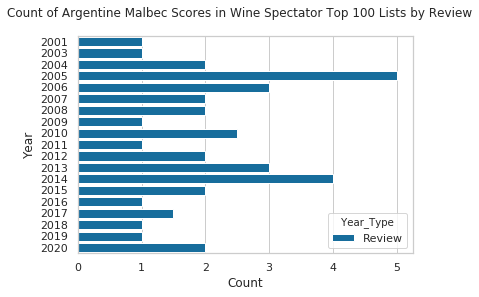

In [23]:
summary_barplot('Review')

### Analysis by Winemaker

In [24]:
# Count of California Zinfandels by Review Year by Winemaker
df_AMW_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Winemaker'])['Score'].count()}).reset_index()

# Count of California Zinfandels by Review Year
df_AMW_Price = pd.DataFrame({'Average_Price' : df_Wine_V.groupby(['Winemaker'])['Price'].mean()}).reset_index()

# Count of California Zinfandels by Review Year
df_AMW_Score = pd.DataFrame({'Average_Score' : df_Wine_V.groupby(['Winemaker'])['Score'].mean()}).reset_index()

frame = [df_AMW_Count, df_AMW_Price, df_AMW_Score]
df_AMW = pd.concat(frame, sort = True, axis = 1)
df_AMW = df_AMW.T.drop_duplicates().T

df_AMW

,Winemaker,Count,Average_Price,Average_Score
0,Achával-Ferrer,6,96.5,94.8333
1,Alta Vista,1,19,91
2,Altocedro,1,30,92
3,Altos Las Hormigas,3,23.3333,91.6667
4,Altos de Medrano,1,24,91
5,Bodega Catena Zapata,6,33.8333,92.1667
6,Bodega Colomé,5,25,91.8
7,Bodega El Esteco,1,16,90
8,Bodega Luigi Bosca,2,27,91
9,Bodega Noemía de Patagonia,1,105,96


In [25]:
# define a function to graph summary data

def winemaker():
    
    df = df_AMW
    
    # Make the pairgrid
    g = sns.PairGrid(df.sort_values(by = 'Average_Score', ascending = False),
                     x_vars = df.columns[1:4],
                     y_vars = df.columns[0],
                     height = 10,
                     aspect = 0.25
                    )
    
    # Draw dot plot using stripplot function
    g.map(sns.stripplot,
          size = 10, 
          orient = 'h',
          jitter = False,
          palette = 'colorblind',
          linewidth = 1,
          edgecolor = 'w')
    
    # Use semantically meaningful titles for the columns
    titles = ['Count', 'Average Price', 'Average Score']
    
    for ax, title in zip(g.axes.flat, titles):
        
        # Set a different title for each axis
        
        ax.set(title = title)
        
        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)

    sns.despine(left = True, bottom = True)
    
    plt.suptitle('Argentine Malbec\nCount, Average Score, and Average Price in Wine Spectator Top 100 Lists\nReview Years 1988-2020', y = 1.1)
    plt.savefig('./images/argenmalbec_dotplot_countscores_byyear.png')
    plt.savefig('./images/argenmalbec_dotplot_countscores_byyear.jpg')

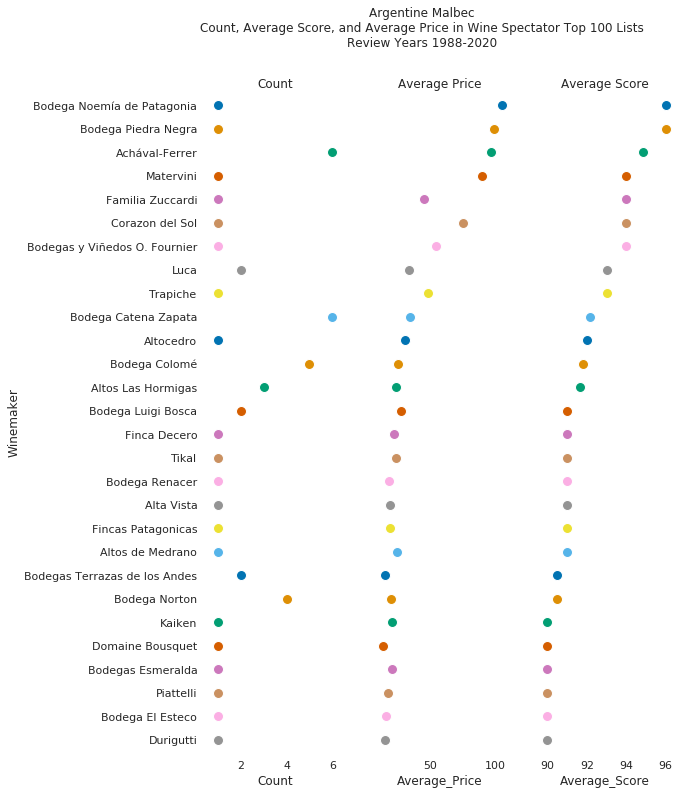

In [26]:
winemaker()